In [1]:
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np
import pydub
import os

In [2]:
# Important frequencies and the colors they correspond to (including higher octaves)
DARKVIOLET = [963, 481.5, 240.75, 120.375]
BLUE = [852, 426, 213, 106.5]
CYAN = [741, 370.5, 185.25, 92.625]
TEAL = [969, 348, 174, 87]
#OLIVEDRAB = [640, 320, 160]
LIME = [639, 319.5, 159.75, 79.875]
MINTCREAM = [570, 285, 142.5, 71.25]
YELLOW = [528, 264, 132, 66]
GOLDENROD = [501.12, 250.56, 125.28]
ORANGE = [417, 208.5, 104.25]
RED = [396, 198, 99]

#lists_of_freqs = [DARKVIOLET, BLUE, CYAN, TEAL, OLIVEDRAB, LIME, MINTCREAM, YELLOW, GOLDENROD, ORANGE, RED]
lists_of_freqs = [DARKVIOLET, BLUE, CYAN, TEAL, LIME, MINTCREAM, YELLOW, GOLDENROD, ORANGE, RED]
for l in lists_of_freqs:
    f = l[0]
    while f <= 11000:
        f *= 2
        l.append(f)

#colors = ['darkviolet', 'blue', 'cyan', 'teal', 'olivedrab', 'lime', 'mintcream', 'yellow', 'goldenrod', 'orange', 'red']
colors = ['darkviolet', 'blue', 'cyan', 'teal', 'lime', 'mintcream', 'yellow', 'goldenrod', 'orange', 'red']

freqs_to_colors = {}
for i in range(len(lists_of_freqs)):
    l = lists_of_freqs[i]
    for f in l:
        freqs_to_colors[f] = colors[i]
important_freqs = sorted(list(freqs_to_colors.keys()))

In [3]:
# Split up frequency spectrum into colored regions
smallest_diff = min([important_freqs[i + 1] - important_freqs[i] for i in range(len(important_freqs) - 1)]) / 2

In [4]:
def read_mp3(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
        y = np.mean(y, axis=1)
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [ ]:
#fs, song = read_mp3('Audio/{}.mp3'.format('004'))
#Audio(song, rate=fs)

In [5]:
def analyze(song, fs):
    f, t, Sxx = signal.spectrogram(song, fs, nfft=44000)
    
    # Count the number of occurences when a frequency has a contribution greater than median + std
    median = np.median(Sxx)
    std = np.std(Sxx)
    count_freq_occurences = np.count_nonzero(Sxx > (median + std), axis=1)
    
    # Largest index of f that has a nonzero number of contributions greater than median + std
    largest_nonzero_index = np.max(np.nonzero(count_freq_occurences))
    freqs = f[:largest_nonzero_index]
    counts = count_freq_occurences[:largest_nonzero_index]
    
    # Freqs where there is a peak in number of contributions greater than median + std
    peak_indices = np.nonzero(np.diff((np.diff(counts) > 0).astype(int)) < 0)
    peak_indices = np.array(peak_indices) + 1
    peak_freqs = [freqs[i] for i in peak_indices]
    
    return f, t, Sxx, median, std, count_freq_occurences, largest_nonzero_index, peak_freqs

In [6]:
def get_indices_of_important_freqs(x):
    results = {freq: None for freq in important_freqs}
    i = 0
    for freq in important_freqs:
        while i < len(x) - 1 and x[i] <= freq:
            i += 1
        if x[i] - freq < freq - x[i - 1]:
            results[freq] = i
        else:
            results[freq] = i - 1
    return results

In [7]:
def median_values_for_each_color_normalized(x, y):
    results = {color: [] for color in colors}
    indices = get_indices_of_important_freqs(x)
    
    largest = 0
    
    for freq in important_freqs:
        value = y[indices[freq]]
        results[freqs_to_colors[freq]].append(value)
        if value > largest:
            largest = value
        
    for color in results:
        results[color] = np.array(results[color]) / largest
        results[color] = np.median(results[color])
    
    return results

In [8]:
def sum_values_for_each_color(x, y):
    results = {color: 0 for color in colors}
    indices = get_indices_of_important_freqs(x)
    
    for freq in important_freqs:
        results[freqs_to_colors[freq]] += y[indices[freq]]
    
    return results

In [9]:
def get_percentage_of_total_magnitude_for_each_color(f, Sxx):
    def trim_zero_cols():
        transposed = Sxx.T
        i = 0
        while i < len(transposed):
            if not np.any(transposed[i]):
                transposed = np.delete(transposed, i, 0)
            else:
                i += 1
        return transposed.T
        
    data = trim_zero_cols()
    y = np.sum(data, axis=0)
    y = data / y
    total_timesteps = np.shape(data)[1]
    y /= total_timesteps
    y *= 100
    
    assert math.isclose(np.sum(y), 100)
    
    results = {color: 0 for color in colors}
    indices = get_indices_of_important_freqs(f)
    
    for freq in important_freqs:
        for t in range(total_timesteps):
            results[freqs_to_colors[freq]] += y[indices[freq]][t]
            
    assert sum(results.values()) <= 100
    
    return results

In [10]:
def get_median_magnitude_for_each_color_normalized(fs, song):
    f, _, Sxx, _, _, _, _, _ = analyze(song, fs)
    x = f
    y = np.sum(Sxx, axis=1)
    results = median_values_for_each_color_normalized(x, y)
    return results

In [ ]:
# def get_total_magnitude_for_each_color_normalized(fs, song):
#     f, _, Sxx, _, _, _, _, _ = analyze(song, fs)
#     x = f
#     y = np.sum(Sxx, axis=1)
#     results = sum_values_for_each_color(x, y)
#     total = sum(results.values())
#     for color in results:
#         results[color] /= total
#     return results

In [ ]:
# root = 'Audio'
# lowest_freq = 60
# for file in os.listdir(root):
#     if file.endswith('.mp3'):
#         print('{} - Reading file'.format(file))
#         fs, song = read_mp3('{}/{}'.format(root, file))
        
#         print('{} - Starting analysis'.format(file))
#         f, t, Sxx, median, std, count_freq_occurences, largest_nonzero_index, peak_freqs = analyze(song, fs)
#         print('{} - Analysis done'.format(file))
        
#         fig = plt.figure(figsize=(40, 30))
#         gs = GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 3])
#         ax1 = fig.add_subplot(gs[0, :])
#         ax2 = fig.add_subplot(gs[1, :], sharex=ax1)
#         ax3 = fig.add_subplot(gs[2, 0])
#         ax4 = fig.add_subplot(gs[2, 1])
#         ax5 = fig.add_subplot(gs[3, :])
        
#         fig.patch.set_facecolor('#ababab')
#         fig.patch.set_alpha(0.5)
#         fig.suptitle(file)
        
#         print('{} - Starting plot 1'.format(file))
        
#         ax1.set_xscale('log')
#         ax1.set_title('Percentage of Total Time Where Frequency Magnitude is Greater than 1 SD + Median')
#         ax1.set_ylabel('Percentage of Total Time (%)')
#         ax1.set_xlabel('Freq [Hz]')
#         ax1.set_facecolor('gray')
        
#         x = f[:largest_nonzero_index]
#         y = count_freq_occurences[:largest_nonzero_index] / len(t) * 100
#         ax1.plot(x, y)
#         ax1.set_xlim(left=lowest_freq)
        
#         for freq in important_freqs:
#             ax1.fill_between(x, y, where=(x > freq - smallest_diff) & (x < freq + smallest_diff), color=freqs_to_colors[freq])
        
#         print('{} - Plot 1 done'.format(file))
        
#         print('{} - Starting plot 2'.format(file))
        
#         results = get_percentage_of_total_magnitude_for_each_color(f, Sxx)
#         ax3.bar(np.arange(len(colors)), [results[color] for color in colors], color=colors)
        
#         ax3.set_title('Percentage of Total Magnitude Per Color')
#         ax3.set_ylabel('Percentage of Total Magnitude (%)')
#         ax3.set_xlabel('Color')
#         ax3.set_xticks(np.arange(len(colors)))
#         ax3.set_xticklabels(colors)
#         ax3.set_facecolor('gray')
        
#         print('{} - Plot 2 done'.format(file))
        
#         print('{} - Starting plot 3'.format(file))
        
#         ax2.set_xscale('log')
#         ax2.set_title('Frequency vs. Total Magnitude')
#         ax2.set_ylabel('Total Magnitude of STFT')
#         ax2.set_xlabel('Freq [Hz]')
#         ax2.set_facecolor('gray')
        
#         x = f
#         y = np.sum(Sxx, axis=1)
#         ax2.plot(x, y)
#         ax2.set_xlim(left=lowest_freq)
        
#         for freq in important_freqs:
#             ax2.fill_between(x, y, where=(x > freq - smallest_diff) & (x < freq + smallest_diff), color=freqs_to_colors[freq])
        
#         print('{} - Plot 3 done'.format(file))
        
#         print('{} - Starting plot 4'.format(file))
        
#         results = sum_values_for_each_color(x, y)
#         ax4.bar(np.arange(len(colors)), [results[color] for color in colors], color=colors)
#         ax4.set_title('Color vs. Total Magnitude')
#         ax4.set_ylabel('Total Magnitude of STFT')
#         ax4.set_xlabel('Color')
#         ax4.set_xticks(np.arange(len(colors)))
#         ax4.set_xticklabels(colors)
#         ax4.set_facecolor('gray')
        
#         print('{} - Plot 4 done'.format(file))
        
#         print('{} - Starting plot 5'.format(file))
        
#         ax5.set_title('Spectrogram')
#         ax5.pcolormesh(t, f[:largest_nonzero_index], Sxx[:largest_nonzero_index], vmax=median + 3 * std, shading='auto')
#         ax5.set_ylabel('Frequency [Hz]')
#         ax5.set_xlabel('Time [sec]')
        
#         print('{} - Plot 5 done'.format(file))
        
#         print('{} - Saving figure'.format(file))
#         fig.savefig('Graphs (including higher octaves)/{}.png'.format(file[:-4]), facecolor=fig.get_facecolor())
#         print('{} - Figure saved'.format(file))

In [11]:
def analyze_category_median_magnitude_for_each_color(root):
    category_results = {color: [] for color in colors}
    for file in os.listdir(root):
        if file.endswith('.mp3'):
            print('{}'.format(file))
            
            fs, song = read_mp3('{}/{}'.format(root, file))
            song_results = get_median_magnitude_for_each_color_normalized(fs, song)
            
            for color in song_results:
                category_results[color].append(song_results[color])
                
    return category_results

In [ ]:
all_results = {color: [] for color in colors}
medians = {color: [] for color in colors}

for file in os.listdir('archive/dataset/Audio/Cluster 5/Aggressive'):
    if file.endswith('.mp3'):
        print('{}'.format(file))
        
        fs, song = read_mp3('archive/dataset/Audio/Cluster 5/Aggressive/{}'.format(file))
        f, _, Sxx, _, _, _, _, _ = analyze(song, fs)
        x = f
        y = np.sum(Sxx, axis=1)
    
        results = {color: [] for color in colors}
        indices = get_indices_of_important_freqs(x)
        
        largest = 0

        for freq in important_freqs:
            value = y[indices[freq]]
            results[freqs_to_colors[freq]].append(value)
            if value > largest:
                largest = value
        
        for color in all_results:
            data = np.array(results[color]) / largest
            all_results[color].append(data)
            medians[color].append(np.median(data))
            
# fig, axs = plt.subplots(len(all_results['red']), len(colors), sharex='all')
# fig.set_size_inches((40, 40))

# for r in range(len(all_results['red'])):
#     for c in range(len(colors)):
#         axs[r, c].scatter(all_results[colors[c]][r], np.zeros_like(all_results[colors[c]][r]))
#         axs[r, c].set_yticks([])

fig, axs = plt.subplots(len(colors), sharex='all')
fig.set_size_inches((8, 40))

for c in range(len(colors)):
    axs[c].scatter(medians[colors[c]], np.zeros_like(medians[colors[c]]))
    axs[c].set_yticks([])

print(colors)

fig.savefig('medians2.png')

In [ ]:
# def analyze_category_total_magnitude_for_each_color(root):
#     category_results = {color: [] for color in colors}
#     for file in os.listdir(root):
#         if file.endswith('.mp3'):
#             print('{}'.format(file))
            
#             fs, song = read_mp3('{}/{}'.format(root, file))
#             song_results = get_total_magnitude_for_each_color_normalized(fs, song)
            
#             for color in song_results:
#                 category_results[color].append(song_results[color])
                
#     return category_results

In [ ]:
brooding_results = analyze_category_total_magnitude_for_each_color('Brooding')

In [ ]:
brooding_medians = {color: np.median(brooding_results[color]) for color in brooding_results}
print('----- Median', brooding_medians)

brooding_stds = {color: np.std(brooding_results[color]) for color in brooding_results}
print('----- Std', brooding_stds)

brooding_means = {color: np.mean(brooding_results[color]) for color in brooding_results}
print('----- Mean', brooding_means)

In [ ]:
color = 'lime'
plt.scatter(brooding_results[color], np.zeros_like(brooding_results[color]))
plt.yticks([])
plt.show()

In [ ]:
labels = list(brooding_medians.keys())
plt.bar(np.arange(len(labels)), [brooding_medians[color] for color in labels] , color=labels)
plt.show()

020.mp3
008.mp3
009.mp3
021.mp3
023.mp3
022.mp3
026.mp3
027.mp3
019.mp3
031.mp3
025.mp3
024.mp3
030.mp3
018.mp3
015.mp3
001.mp3
029.mp3
028.mp3
014.mp3
002.mp3
016.mp3
017.mp3
003.mp3
007.mp3
013.mp3
012.mp3
006.mp3
010.mp3
004.mp3
005.mp3
011.mp3
183.mp3
197.mp3
196.mp3
182.mp3
194.mp3
180.mp3
181.mp3
195.mp3
191.mp3
185.mp3
184.mp3
190.mp3
179.mp3
186.mp3
192.mp3
193.mp3
187.mp3
178.mp3
203.mp3
175.mp3
174.mp3
202.mp3
200.mp3
176.mp3
189.mp3
188.mp3
177.mp3
201.mp3
205.mp3
173.mp3
198.mp3
199.mp3
172.mp3
204.mp3
171.mp3


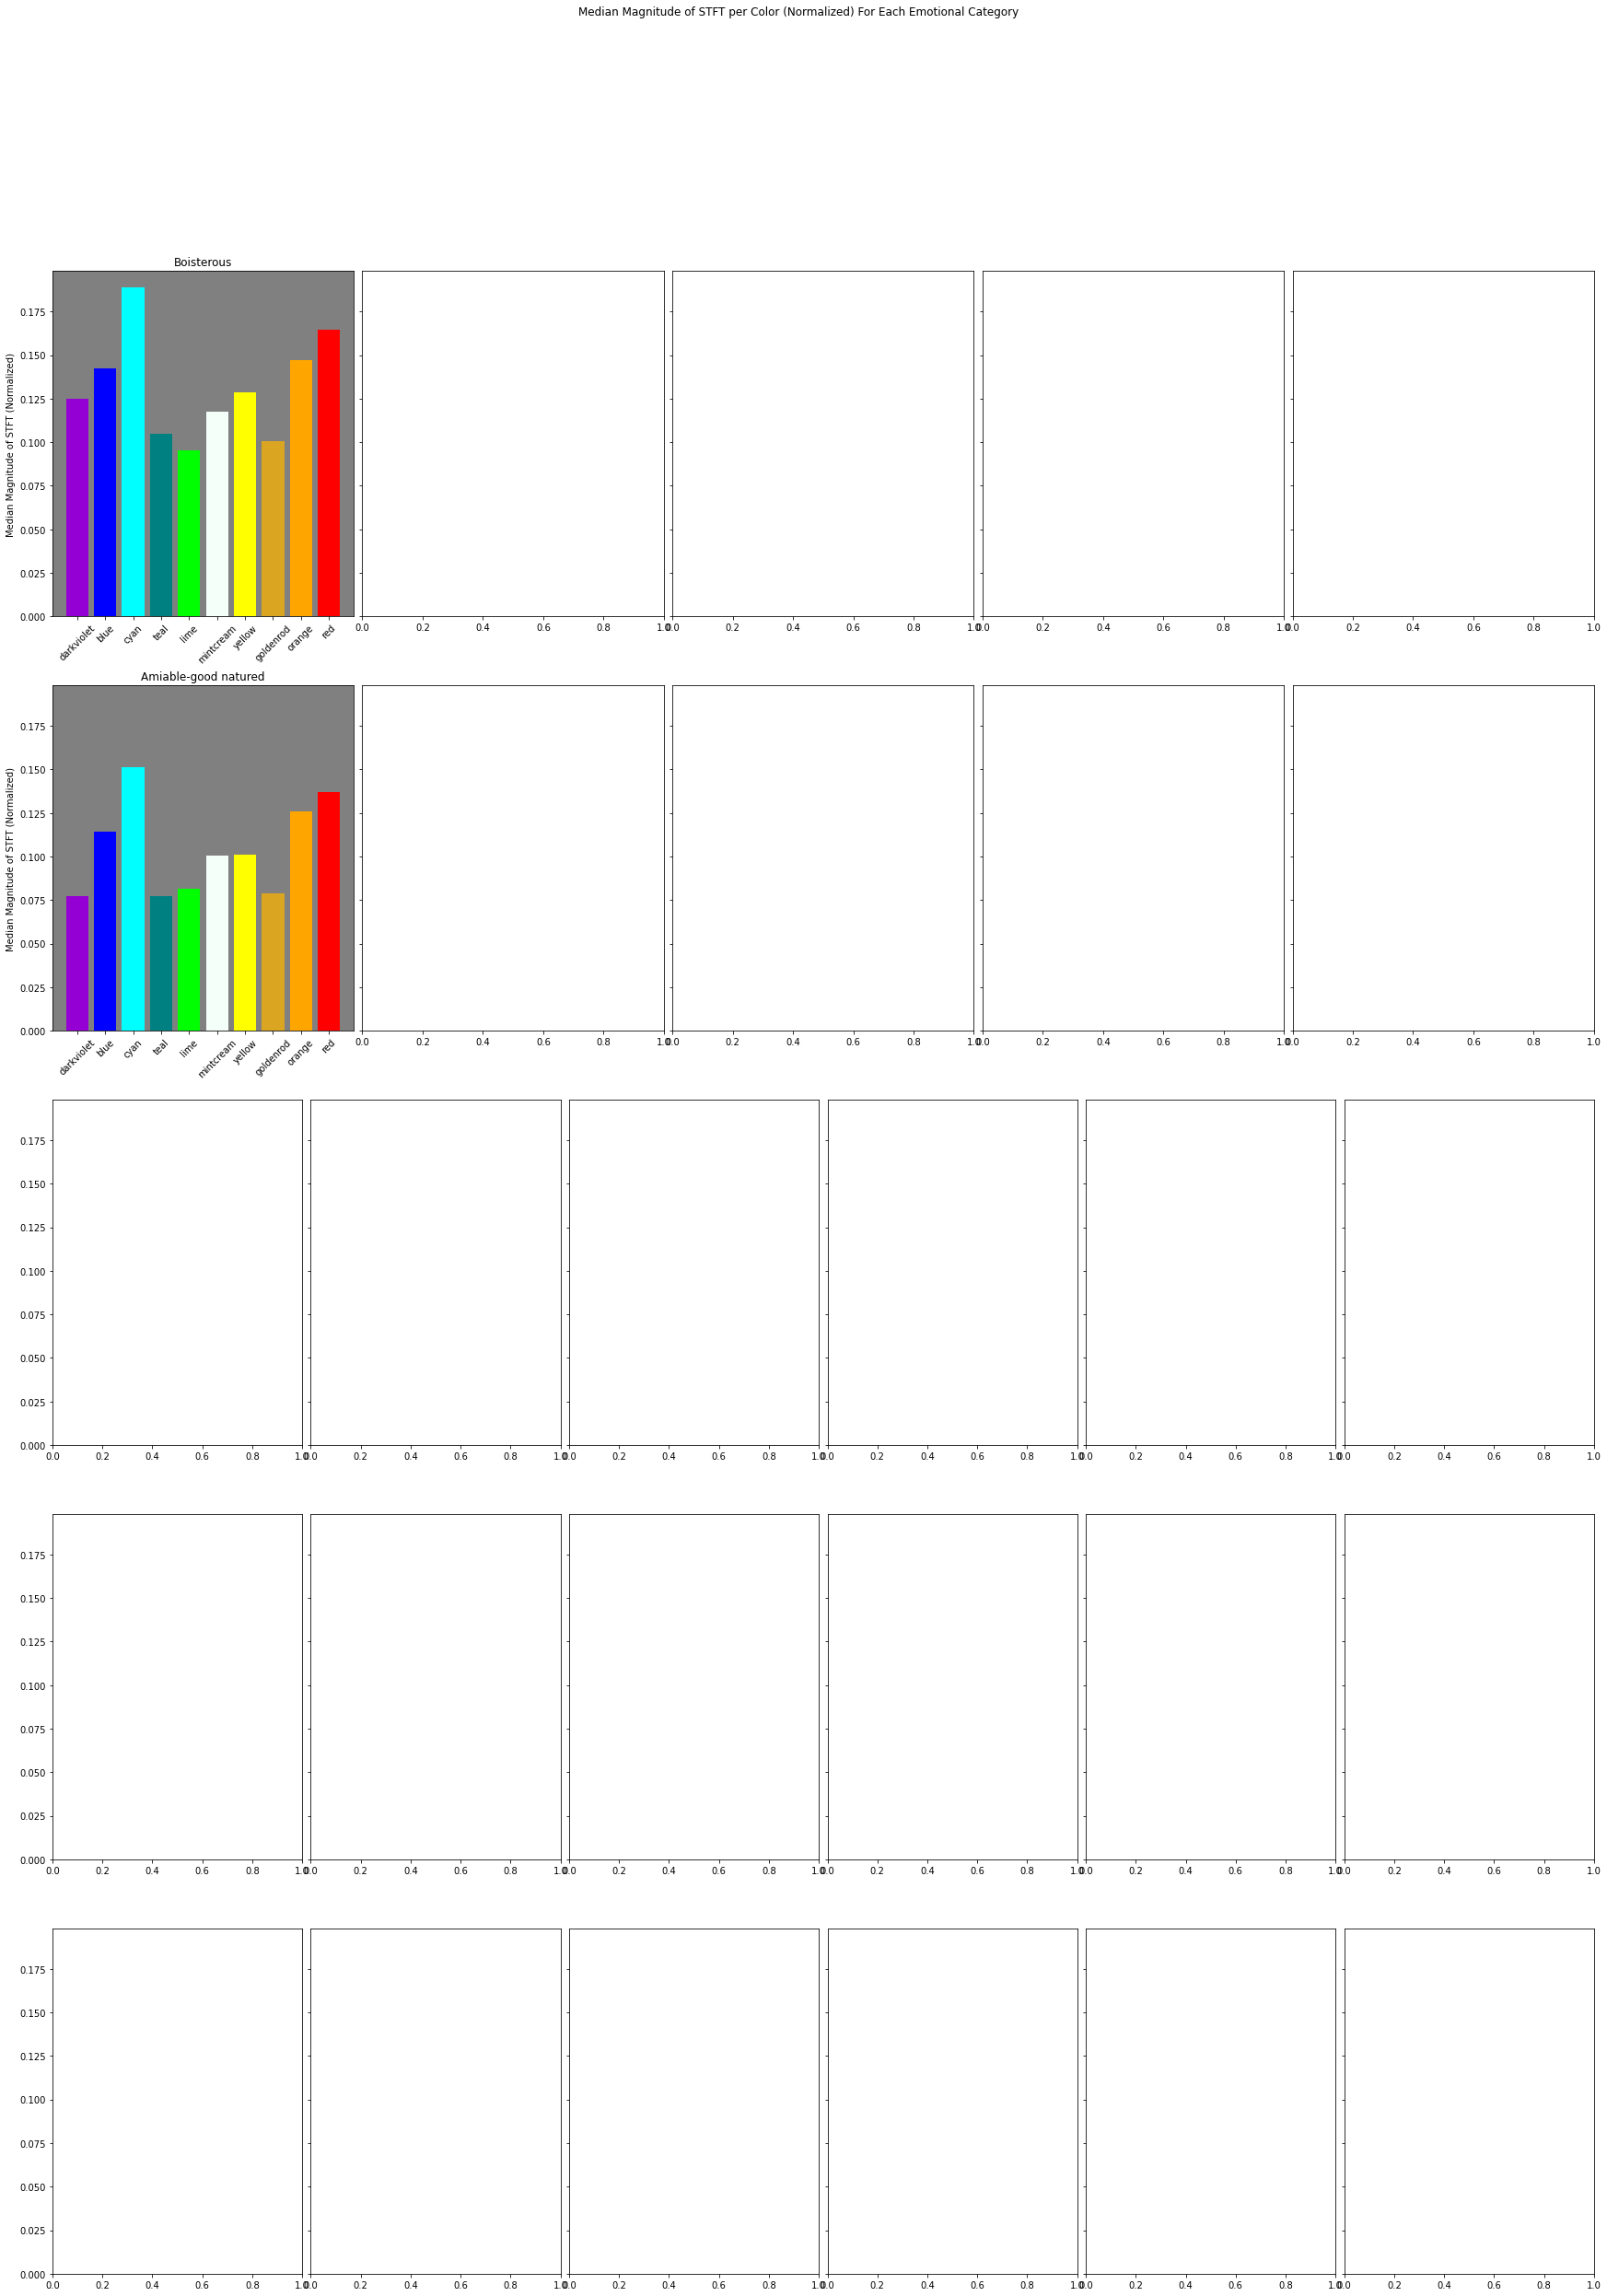

In [16]:
fig = plt.figure(figsize=(30, 40))
gs = GridSpec(5, 30, figure=fig)

ax1_1 = fig.add_subplot(gs[0, 0:6])
ax1_2 = fig.add_subplot(gs[0, 6:12], sharey=ax1_1)
ax1_3 = fig.add_subplot(gs[0, 12:18], sharey=ax1_2)
ax1_4 = fig.add_subplot(gs[0, 18:24], sharey=ax1_3)
ax1_5 = fig.add_subplot(gs[0, 24:], sharey=ax1_4)
plt.setp(ax1_2.get_yticklabels(), visible=False)
plt.setp(ax1_3.get_yticklabels(), visible=False)
plt.setp(ax1_4.get_yticklabels(), visible=False)
plt.setp(ax1_5.get_yticklabels(), visible=False)

ax2_1 = fig.add_subplot(gs[1, 0:6], sharex=ax1_1, sharey=ax1_1)
ax2_2 = fig.add_subplot(gs[1, 6:12], sharex=ax1_2, sharey=ax2_1)
ax2_3 = fig.add_subplot(gs[1, 12:18], sharex=ax1_3, sharey=ax2_2)
ax2_4 = fig.add_subplot(gs[1, 18:24], sharex=ax1_4, sharey=ax2_3)
ax2_5 = fig.add_subplot(gs[1, 24:], sharex=ax1_5, sharey=ax2_4)
plt.setp(ax2_2.get_yticklabels(), visible=False)
plt.setp(ax2_3.get_yticklabels(), visible=False)
plt.setp(ax2_4.get_yticklabels(), visible=False)
plt.setp(ax2_5.get_yticklabels(), visible=False)

ax3_1 = fig.add_subplot(gs[2, 0:5], sharey=ax1_1)
ax3_2 = fig.add_subplot(gs[2, 5:10], sharey=ax3_1)
ax3_3 = fig.add_subplot(gs[2, 10:15], sharey=ax3_2)
ax3_4 = fig.add_subplot(gs[2, 15:20], sharey=ax3_3)
ax3_5 = fig.add_subplot(gs[2, 20:25], sharey=ax3_4)
ax3_6 = fig.add_subplot(gs[2, 25:], sharey=ax3_5)
plt.setp(ax3_2.get_yticklabels(), visible=False)
plt.setp(ax3_3.get_yticklabels(), visible=False)
plt.setp(ax3_4.get_yticklabels(), visible=False)
plt.setp(ax3_5.get_yticklabels(), visible=False)
plt.setp(ax3_6.get_yticklabels(), visible=False)

ax4_1 = fig.add_subplot(gs[3, 0:5], sharex=ax3_1, sharey=ax1_1)
ax4_2 = fig.add_subplot(gs[3, 5:10], sharex=ax3_2, sharey=ax4_1)
ax4_3 = fig.add_subplot(gs[3, 10:15], sharex=ax3_3, sharey=ax4_2)
ax4_4 = fig.add_subplot(gs[3, 15:20], sharex=ax3_4, sharey=ax4_3)
ax4_5 = fig.add_subplot(gs[3, 20:25], sharex=ax3_5, sharey=ax4_4)
ax4_6 = fig.add_subplot(gs[3, 25:], sharex=ax3_6, sharey=ax4_5)
plt.setp(ax4_2.get_yticklabels(), visible=False)
plt.setp(ax4_3.get_yticklabels(), visible=False)
plt.setp(ax4_4.get_yticklabels(), visible=False)
plt.setp(ax4_5.get_yticklabels(), visible=False)
plt.setp(ax4_6.get_yticklabels(), visible=False)

ax5_1 = fig.add_subplot(gs[4, 0:5], sharex=ax4_1, sharey=ax1_1)
ax5_2 = fig.add_subplot(gs[4, 5:10], sharex=ax4_2, sharey=ax5_1)
ax5_3 = fig.add_subplot(gs[4, 10:15], sharex=ax4_3, sharey=ax5_2)
ax5_4 = fig.add_subplot(gs[4, 15:20], sharex=ax4_4, sharey=ax5_3)
ax5_5 = fig.add_subplot(gs[4, 20:25], sharex=ax4_5, sharey=ax5_4)
ax5_6 = fig.add_subplot(gs[4, 25:], sharex=ax4_6, sharey=ax5_5)
plt.setp(ax5_2.get_yticklabels(), visible=False)
plt.setp(ax5_3.get_yticklabels(), visible=False)
plt.setp(ax5_4.get_yticklabels(), visible=False)
plt.setp(ax5_5.get_yticklabels(), visible=False)
plt.setp(ax5_6.get_yticklabels(), visible=False)

fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.5)
fig.suptitle('Median Magnitude of STFT per Color (Normalized) For Each Emotional Category')

def plot_magnitude_per_color(cluster, category, ax, ylabel=False):
    results = analyze_category_median_magnitude_for_each_color('archive/dataset/Audio/Cluster {}/{}'.format(cluster, category))
    medians = {color: np.median(results[color]) for color in results}

    ax.bar(np.arange(len(colors)), [medians[color] for color in colors] , color=colors)
    ax.set_title(category)
    if ylabel:
        ax.set_ylabel('Median Magnitude of STFT (Normalized)')
    #ax.set_xlabel('Color')
    ax.set_xticks(np.arange(len(colors)))
    ax.set_xticklabels(colors, rotation=45)
    ax.set_facecolor('gray')
            
    return medians
    
boisterous = plot_magnitude_per_color(1, 'Boisterous', ax1_1, ylabel=True)
confident = plot_magnitude_per_color(1, 'Confident', ax1_2)
passionate = plot_magnitude_per_color(1, 'Passionate', ax1_3)
rousing = plot_magnitude_per_color(1, 'Rousing', ax1_3)
rowdy = plot_magnitude_per_color(1, 'Rowdy', ax1_5)

amiable_good_natured = plot_magnitude_per_color(2, 'Amiable-good natured', ax2_1, ylabel=True)
cheerful = plot_magnitude_per_color(2, 'Cheerful', ax2_2)
fun = plot_magnitude_per_color(2, 'Fun', ax2_3)
rollicking = plot_magnitude_per_color(2, 'Rollicking', ax2_4)
sweet = plot_magnitude_per_color(2, 'Sweet', ax2_5)

aggressive = plot_magnitude_per_color(5, 'Aggressive', ax5_1, ylabel=True)
fiery = plot_magnitude_per_color(5, 'Fiery', ax5_2)
intense = plot_magnitude_per_color(5, 'Intense', ax5_3)
tense_anxious = plot_magnitude_per_color(5, 'Tense - Anxious', ax5_4)
visceral = plot_magnitude_per_color(5, 'Visceral', ax5_5)
volatile = plot_magnitude_per_color(5, 'Volatile', ax5_6)

fig.savefig('Categories2.png', facecolor=fig.get_facecolor())

In [ ]:
# fig = plt.figure(figsize=(40, 40))
# gs = GridSpec(5, 30, figure=fig)

# ax1_1 = fig.add_subplot(gs[0, 0:6])
# ax1_2 = fig.add_subplot(gs[0, 6:12], sharey=ax1_1)
# ax1_3 = fig.add_subplot(gs[0, 12:18], sharey=ax1_2)
# ax1_4 = fig.add_subplot(gs[0, 18:24], sharey=ax1_3)
# ax1_5 = fig.add_subplot(gs[0, 24:], sharey=ax1_4)

# ax2_1 = fig.add_subplot(gs[1, 0:6], sharex=ax1_1)
# ax2_2 = fig.add_subplot(gs[1, 6:12], sharex=ax1_2, sharey=ax2_1)
# ax2_3 = fig.add_subplot(gs[1, 12:18], sharex=ax1_3, sharey=ax2_2)
# ax2_4 = fig.add_subplot(gs[1, 18:24], sharex=ax1_4, sharey=ax2_3)
# ax2_5 = fig.add_subplot(gs[1, 24:], sharex=ax1_5, sharey=ax1_4)

# ax3_1 = fig.add_subplot(gs[2, 0:5])
# ax3_2 = fig.add_subplot(gs[2, 5:10], sharey=ax3_1)
# ax3_3 = fig.add_subplot(gs[2, 10:15], sharey=ax3_2)
# ax3_4 = fig.add_subplot(gs[2, 15:20], sharey=ax3_3)
# ax3_5 = fig.add_subplot(gs[2, 20:25], sharey=ax3_4)
# ax3_6 = fig.add_subplot(gs[2, 25:], sharey=ax3_5)

# ax4_1 = fig.add_subplot(gs[3, 0:5], sharex=ax3_1)
# ax4_2 = fig.add_subplot(gs[3, 5:10], sharex=ax3_2, sharey=ax4_1)
# ax4_3 = fig.add_subplot(gs[3, 10:15], sharex=ax3_3, sharey=ax4_2)
# ax4_4 = fig.add_subplot(gs[3, 15:20], sharex=ax3_4, sharey=ax4_3)
# ax4_5 = fig.add_subplot(gs[3, 20:25], sharex=ax3_5, sharey=ax4_4)
# ax4_6 = fig.add_subplot(gs[3, 25:], sharex=ax3_6, sharey=ax4_5)

# ax5_1 = fig.add_subplot(gs[4, 0:5], sharex=ax4_1)
# ax5_2 = fig.add_subplot(gs[4, 5:10], sharex=ax4_2, sharey=ax5_1)
# ax5_3 = fig.add_subplot(gs[4, 10:15], sharex=ax4_3, sharey=ax5_2)
# ax5_4 = fig.add_subplot(gs[4, 15:20], sharex=ax4_4, sharey=ax5_3)
# ax5_5 = fig.add_subplot(gs[4, 20:25], sharex=ax4_5, sharey=ax5_4)
# ax5_6 = fig.add_subplot(gs[4, 25:], sharex=ax4_6, sharey=ax5_5)

# fig.patch.set_facecolor('#ababab')
# fig.patch.set_alpha(0.5)
# fig.suptitle('Median Total Magnitude of STFT per Color (Normalized) For Each Emotional Category')

# def plot_magnitude_per_color(cluster, category, ax):
#     results = analyze_category_total_magnitude_for_each_color('archive/dataset/Audio/Cluster {}/{}'.format(cluster, category))
#     medians = {color: np.median(results[color]) for color in results}

#     ax.bar(np.arange(len(colors)), [medians[color] for color in colors] , color=colors)
#     ax.set_title(category)
#     ax.set_ylabel('Total Magnitude of STFT (Normalized)')
#     ax.set_xlabel('Color')
#     ax.set_xticks(np.arange(len(colors)))
#     ax.set_xticklabels(colors, rotation='vertical')
#     ax.set_facecolor('gray')
            
#     return medians
    
# plot_magnitude_per_color(1, 'Boisterous', ax1_1)
# plot_magnitude_per_color(1, 'Confident', ax1_2)

# plot_magnitude_per_color(2, 'Amiable-good natured', ax2_1)

# fig.savefig('Categories.png', facecolor=fig.get_facecolor())